<a href="https://colab.research.google.com/github/LawZhou/AtChannel-decentralized-video-platform/blob/master/MIE1624_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/clean_kaggle_data_2020.csv",
                 low_memory=False)
# df = pd.read_csv("data/clean_kaggle_data.csv", low_memory=False)
features = df.iloc[1:, :-2].copy()
targets = df.iloc[1:, -2].copy()

# Question 1: Data cleaning

In [2]:
num_col = ['Time from Start to Finish (seconds)']
not_mc_cols = []
for col in features.columns:
  if '_' not in col and col not in num_col:
    not_mc_cols.append(col)
not_mc_cols

['Q1',
 'Q2',
 'Q3',
 'Q4',
 'Q5',
 'Q6',
 'Q8',
 'Q11',
 'Q13',
 'Q15',
 'Q20',
 'Q21',
 'Q22',
 'Q24',
 'Q25',
 'Q30',
 'Q32',
 'Q38']

In [3]:
mc_cols = []
for col in features.columns:
  if col not in not_mc_cols and col not in num_col:
    mc_cols.append(col)

In [4]:
for col in not_mc_cols:
  features[col] = pd.factorize(features[col])[0]

In [5]:
dummies = features[mc_cols].fillna(0)
dummies[dummies != 0] = 1
features[mc_cols] = dummies

# Split train test

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     features, targets, test_size=0.2, random_state=42)
print(f"Shape of train features: {X_train.shape}")
print(f"Shape of test features: {X_test.shape}")

Shape of train features: (8583, 355)
Shape of test features: (2146, 355)


# Question 2: Exploratory data analysis and feature selection 

## feature importance

In [7]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

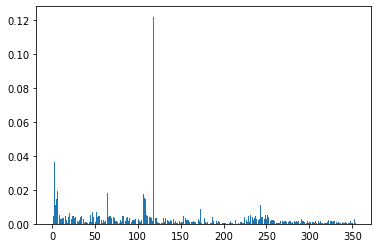

In [8]:
from matplotlib import pyplot
# get importance
importance = model.feature_importances_
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## Feature selection

In [21]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
# sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel = SelectKBest(mutual_info_classif, k=40)
X_train = sel.fit_transform(X_train, y_train)
X_test = sel.transform(X_test)

# Question 3 Model implementation